/# Artificial Intelligence Course - Fall 1402 
/## Computer Assignment #6 - Clustering 

/### Mehdi Jamalkhah, SID: 810100111 

### Table of Contents<a id='toc0_'></a>    
- [Introduction](#toc1_)    
- [Data Set](#toc2_)    
- [Preprocessing Data](#toc3_)    
  - [Stop Words](#toc3_1_)    
  - [Stemming](#toc3_2_)    
  - [Lemmatization](#toc3_3_)    
- [Document to Vector](#toc4_)    
  - [Word2vec](#toc4_1_)    
  - [Doc2vec](#toc4_2_)    
    - [PV-DM](#toc4_2_1_)    
    - [PV-DBOW](#toc4_2_2_)    
  - [Train Model](#toc4_3_)    
  - [Testing the Model](#toc4_4_)    
- [Clustering](#toc5_)    
  - [KMeans](#toc5_1_)        
  - [DBSCAN](#toc5_2_)          
- [PCA](#toc6_)    
  - [KMeans](#toc6_1_)    
  - [DBSCAN](#toc6_2_)    
- [Evaluation](#toc7_)    
  - [Homogeneity Score](#toc7_1_)    
  - [Silhouette Score](#toc7_2_)    
  - [Results](#toc7_3_)    
- [Further Improvements and Recommendations](#toc8_)    
- [Refrences](#toc9_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import pandas as pd
import numpy as np
import random
import collections
import re

from hazm import word_tokenize
from hazm import Lemmatizer
from hazm import Stemmer
from hazm import stopwords_list
from hazm import Normalizer

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import multiprocessing

import matplotlib.pyplot as plt


## <a id='toc1_'></a>Introduction [](#toc0_)
In this computer assignment, our objective is to explore clustering algorithms by applying them to a text dataset. The dataset comprises news articles sourced from [asriran](https://www.asriran.com/), and our aim is to cluster them.

To accomplish this, we begin by converting the text dataset into a **vector representation**. Subsequently, we utilize the **KMeans** and **DBSCAN** algorithms to cluster the data. Once the clustering is complete, we proceed to visualize the results using PCA (Principal Component Analysis). Finally, we evaluate the quality of the clusters using the Homogeneity and Silhouette scores.

## <a id='toc2_'></a>Data Set [](#toc0_)

Our dataset consists of news articles from various types.

In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

train_size = train_df.shape[0]
test_size = test_df.shape[0]

print("Data counts:")
print(f"\u25CF train: {train_size}")
print(f"\u25CF test:  {test_size}")

Data counts:
● train: 9000
● test:  1115


In [3]:
train_df[:5]

,label,content
0,فناوری,گزارش های منتشر شده حاکی از آن است که کاربران ...
1,ورزشی,سوپر استار سینما و از قهرمانان سابق ووشو ــ کو...
2,حوادث,مدیرعامل شرکت عمران آب کیش از فوت یک نفر در آت...
3,فناوری,یک نوجوان انگلیسی به اتهام هک حساب‌های کاربری ...
4,سلامت,دانشمندان در جدیدترین مطالعات خود اثرات جدید و...


In [4]:
test_df[:5]

,label,content
0,فناوری,بعد از اعلام لیست ۲۳ شرکت مجاز ثبت سفارش و ارا...
1,فرهنگی/هنری,یک استاد علم قرائت قرآن کریم، گفت: ریشه موسیقی...
2,حوادث,آتش سوزی های زنجیره ای جنگل های زاگرس در استان...
3,فناوری,استفاده از سرویس‌های iMassage یا Facetime محصو...
4,حوادث,دادستان عمومی و انقلاب یاسوج گفت: 10 میلیون دل...


In [5]:
print("Counts of labels in the training data:")
train_df['label'].value_counts()

Counts of labels in the training data:


فناوری         1500
ورزشی          1500
حوادث          1500
سلامت          1500
سیاسی          1500
فرهنگی/هنری    1500
Name: label, dtype: int64

In [6]:
print("Counts of labels in the testing data:")
test_df['label'].value_counts()

Counts of labels in the testing data:


حوادث          200
سیاسی          200
ورزشی          190
فرهنگی/هنری    180
سلامت          177
فناوری         168
Name: label, dtype: int64

In this data set all classes have the same number of samples but if it was unbalanced we should do something about that.

**Unbalanced Classes**

When the number of samples in each class is not the same, it can potentially affect clustering algorithms.
If one class is significantly larger than the others, it may dominate the clustering process and lead to biased results. Clustering algorithms often rely on density or distance-based metrics, a class with a larger number of samples may appear more dense simply due to its size, potentially merging clusters or creating artificial structures.

To address these challenges, we can consider the following solutions:

* Undersampling the larger class or oversampling the smaller class can help create a more balanced representation. 

* Some clustering algorithms allow us to assign weights to samples based on their class membership. By assigning higher weights to samples from the smaller classes, we can give them more importance during the clustering process, effectively mitigating the impact of class imbalance.


## <a id='toc3_'></a>Preprocessing Data [](#toc0_)

### <a id='toc3_1_'></a>Stop Words [](#toc0_)
We will remove words that have a high frequency but do not correlate with the target feature.

### <a id='toc3_2_'></a>Stemming [](#toc0_)
Stemming is the process of reducing words to their base or root form by removing prefixes or suffixes. The resulting form may not be an actual word, but it still represents the core meaning of the word

### <a id='toc3_3_'></a>Lemmatization [](#toc0_)
Lemmatization, on the other hand, involves reducing words to their base or dictionary form, called the lemma. Unlike stemming, lemmatization ensures that the resulting form is a valid word.

By making these two replacements, we can overlook the differences between words that have the same meaning but varying appearances.
 

In [8]:
normalizer = Normalizer()
stop_words = stopwords_list()
lemmatizer = Lemmatizer()
stemmer = Stemmer()

PUNCTUATION_PATTERN = r'[^\w\s]'
NUMBER_PATTERN = r'\d+'

In [18]:
# Preprocessing
def normalize(text):
    return normalizer.normalize(text)

def remove_punctuation(text):
    return re.sub(PUNCTUATION_PATTERN, '', text)

def remove_numbers(text):
    return re.sub(NUMBER_PATTERN, '00', text)

def tokenize(text):
    return word_tokenize(text)

def remove_stopwords(text):
    return [token for token in text if token not in stop_words]
    
def lemmatize(text):
    return [lemmatizer.lemmatize(word) for word in text]

def stem(text):
    return [stemmer.stem(word) for word in text] 

def preprocess_text(text):
    text = normalize(text)
    text = remove_punctuation(text)
    text = remove_numbers(text)
    text = tokenize(text)
    text = remove_stopwords(text)
    text = lemmatize(text)
    # text = stem(text)
    return text


train_df['content'] = train_df['content'].apply(preprocess_text)
test_df['content'] = test_df['content'].apply(preprocess_text)

In [19]:
def tagged_doc(df):
    return [TaggedDocument(words=doc, tags=[tag]) for doc, tag in zip(df['content'], df['label'])]
    
train_corpus = tagged_doc(train_df)
test_corpus = tagged_doc(test_df)

y_train = train_df['label'].copy(deep=True)
y_test = test_df['label'].copy(deep=True)

However, in this specific project, the `lemmatizer` did not have a significant effect, but I decided to leave it there.

Let’s take a look at the training corpus:

In [20]:
train_corpus[0:4]

[TaggedDocument(words=['گزارش', 'منتشر', 'حاکی', 'کاربر', 'تلگرام', 'مناطقی', 'جهان', 'اروپا', 'خاورمیانه', 'مشکل', 'شدهاند', 'گزارش', 'ایسنا', 'نقل', 'تلگرام', 'دقایق', 'پیامرسان', 'تلگرام', 'صفحه', 'توییتر', 'اعلام', 'دسترسی', 'کاربر', 'اپلیکیشن', 'اروپا', 'خاورمیانه', 'مشکل', 'پیام', 'میرسد', 'منشا', 'اختلالات', 'ظهر', 'امروز', 'پنجشنبه', 'خارجی', 'پیامرسان', 'ارتباطی', 'داخل', 'کشور', 'پیامرسان', 'عنوان', 'متخصص', 'تلگرام', 'زمانی', 'متوجه', 'اختلال', 'شدهاند', 'بررسی', 'برطرف', 'مشکل', 'مربوطه', 'امید', 'زودی', 'اختلال', 'رفع', 'کاربر', 'حساب', 'کاربری', 'تلگرام', 'دسترسی', 'یابید#یاب'], tags=['فناوری']),
 TaggedDocument(words=['سوپر', 'استار', 'سینما', 'قهرمان', 'سابق', 'ووشو', 'کونگفو', 'حضور', 'شهر', 'شانگهای', 'مسابقات', 'ووشو', 'قهرمانی', 'جهان', 'شاهد', 'گزارش', 'روابط', 'عمومی', 'فدراسیون', 'ووشو', 'آنتونی', 'گو', 'نایبرئیس', 'اجرایی', 'فدراسیون', 'جهانی', 'ووشو', 'افتخار', 'اعلام', 'جت', 'لی', 'محل', 'برگزاری', 'رقابت', 'ووشو', 'قهرمانی', 'بزرگسال', 'جهان', 'حضور', 'بههم',

And the testing corpus looks like this:

In [21]:
test_corpus[0:4]

[TaggedDocument(words=['اعلام', 'لیست', '00', 'شرکت', 'مجاز', 'ثبت', 'سفارش', 'ارائه', 'خدمات', 'فروش', 'تلفن', 'همراه', 'سازمان', 'حمایت', 'تولیدکنندگان', 'مصرفکنندگان', 'بخش', 'لیست', 'اصلاح', 'گزارش', 'ایسنا', 'چندی', 'مصوب', 'تصمیم', 'ثبت', 'سفارش', 'کالا', 'مصرفی', 'خدمات', 'فروش', 'طریق', 'نمایندگی', 'رسمی', 'صورت', 'گرفت#گیر', 'تصمیم', 'اتخاذ', 'گشایش', 'برجا', 'صورت', 'شرکت', 'ایرانی', 'اخذ', 'نمایندگی', 'شرکت', 'صاحبنام', 'خارجی', 'کردهاند', 'دلیل', 'الزامات', 'شکل', 'بازار', 'خودرو', 'تلفن', 'همراه', 'مناقشات', 'بازار', 'واردات', 'ارائه', 'خدمات', 'فروش', 'تلفن', 'همراه', 'اپل', 'عملا', 'اخذ', 'نمایندگی', 'کشور', 'آمریکا', 'داشت#دار', 'شرکت', 'اپل', 'تمایل', 'اعطا', 'نمایندگی', 'محصولات', 'ایران', 'نشان', 'داد#ده', 'تقاضای', 'خرید', 'محصولات', 'بازار', 'تلفن', 'همراه', 'ایران', 'سازمان', 'توسعه', 'تجارت', 'سازمان', 'حمایت', 'مصرفکنندگان', 'تولیدکنندگان', 'موضوع', 'طرح', 'آورد#آور', 'طرح', 'شرکت', 'امضاء', 'برجا', 'خاطر', 'دسترسی', 'شرکت', 'اصلی', 'میتوانستند', 'راحتی', 'مجوز'

## <a id='toc4_'></a>Document to Vector [](#toc0_)
All the algorithms we currently have are designed to operate with numerical data. However, in our case, we are dealing with text, so it becomes necessary to find a method to convert our textual data into a numerical representation, such as a vector. The primary concern is how to encode similarities and other language-specific features into a numeric vector. In the following section, we will delve further into this topic.

### <a id='toc4_1_'></a>Word2vec [](#toc0_)

We’re going to train the neural network to do the following. Given a specific word in the middle of a sentence (the input word), look at the words nearby and pick one at random. The network is going to tell us the probability for every word in our vocabulary of being the “nearby word” that we chose.

We’ll train the neural network to do this by feeding it word pairs ,that are nearby to each other, found in our training documents.

We’re going to represent an input word as a one-hot vector. The length of that vector is equal to number of all word that we have, which we call it our dictionary. 

For our example, we’re going to say that we’re learning word vectors with $M$ features. So the hidden layer is going to be represented by a weight matrix with $N$ rows (one for every word in our vocabulary) and $M$ columns (one for every hidden neuron).

If you look at the rows of this weight matrix, these are actually what will be our word vectors!

If two different words have very similar “contexts” (that is, what words are likely to appear around them), then our model needs to output very similar results for these two words. And one way for the network to output similar context predictions for these two words is if the word vectors are similar. So, if two words have similar contexts, then our network is motivated to learn similar word vectors for these two words!


### <a id='toc4_2_'></a>Doc2vec [](#toc0_)
The goal of doc2vec is to create a numeric representation of a document, regardless of its length. But unlike words, documents do not come in logical structures such as words, so the another method has to be found.

The concept that Mikilov and Le have used was simple, yet clever: they have used the word2vec model, and added another vector (Paragraph ID).



#### <a id='toc4_2_1_'></a>PV-DM [](#toc0_)
Randomly sample consecutive words from a paragraph and predict a center word from the randomly sampled set of words by taking as input — the context words and a paragraph id.

#### <a id='toc4_2_2_'></a>PV-DBOW [](#toc0_)
Distributed Bag Of Words (DBOW) model is slightly different from the PVDM model. The DBOW model “ignores the context words in the input, but force the model to predict words randomly sampled from the paragraph in the output.” For the above example, let’s say that the model is learning by predicting 2 sampled words.

In this example, as I experimented with both algorithms mentioned, I found that **PV-DBOW** (`dm=0`) yielded better results. This indicates that the importance of words in a particular type of news outweighs the context in which those words are used.

>**How determine the `vector_size`?** 
    <br>
    Word2Vec captures distributed representation of a word which essentially means, multiple neurons capture a single concept (concept can be word meaning/sentiment/part of speech etc.), and also a single neuron contributes to multiple concepts.
    <br>
    <br>
    These concepts are automatically learnt and not pre-defined, hence we can think of them as latent/hidden. Also for the same reason, the word vectors can be used for multiple applications.
    <br>
    <br>
    More is the size parameter, more will be the capacity of our neural network to represent these concepts, but more data will be required to train these vectors (as they are initialised randomly). In absence of sufficient number of sentences/computing power, its better to keep the size small.
    <br>
    <br>
    Doc2Vec follows slightly different neural network architecture as compared to Word2Vec, but the meaning of size is analogous.

In [22]:
VECTOR_SIZE = 5
MIN_COUNT = 1
EPOCHS = 100

model = Doc2Vec(dm=0, vector_size=VECTOR_SIZE, min_count=MIN_COUNT, epochs=EPOCHS, workers=multiprocessing.cpu_count())

Build a vocabulary

In [23]:
model.build_vocab(train_corpus)

### <a id='toc4_3_'></a>Train Model [](#toc0_)
Next, train the model on the corpus.

In [24]:
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

Now we'll infer the vector of train and test data

In [25]:
train_vector = [model.infer_vector(train_corpus[i].words) for i in range(train_size)]
test_vector = [model.infer_vector(test_corpus[i].words) for i in range(test_size)]

### <a id='toc4_4_'></a>Testing the Model [](#toc0_)
Using the same approach above, we’ll infer the vector for a randomly chosen test document, and compare the document to our model by eye

In [14]:
doc_id = random.randint(0, test_size -1)
inferred_vector = test_vector[doc_id]
sims = model.dv.most_similar([inferred_vector], topn=len(model.dv))

text = ' '.join(test_corpus[doc_id].words)
print(f'Test Document ({doc_id}): «{text}»\n')

print(f'SIMILAR/DISSIMILAR DOCS PER MODEL Doc2Vec:\n')
for label, index in [('MOST', 0), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    text = ' '.join(train_corpus[sims[index][0]].words)
    print(f'{label} ({sims[index][1]}): {text}\n')

Test Document (707): «صحب بازار میان‌رده معمول انتظار گوشی ساده دوا نه‌چند طولان ؛ هوآو ساخ محصول Huawei Y 9 2019 ن گوشید#گو میان‌رده انتظار سطح بالا کیف . داشتنِ پرچم‌دار قدرتمند ، جزء شرک توانا ساخ گوشی میان‌رده . استفاده فناور رده مواد اولیه کیف دق بالا ت طراح محصول شرک Huawei Y 9 2019 باکیف خو ساخ ، میان‌رده بتو ز طولان ، عملکرد انتظار . معرف نسخه سال 2019 گوشید#گو محبوب Huawei Y 9 ، شرک توانسته محصول خلق استاندارد بحث کیف ساخ ، تو پرداز ، دوربین خصوص رنج قیمت رعا . Huawei Y 9 2019 بدنه جنس پل کربن آلومینیو ساخته مقاوم بالا فشار ضربه . ترا بر بدنه زیباس یک‌دس جلوه . Huawei Y 9 2019 دوربین دوگانه دستگاه گرفت#گیر سنسور ماژول عمق مید ؛ سنسور کاربر توانست#تو فوکوس دقیق‌تر سوژه اضافه افک تصویر ( تار زمینه ایجاد جلوه هنر ) ، عملکرد مطلوب ن . هو مصنوع قابل Huawei Y 9 2019 . صور هو مصنوع گوشی هوآو سال 2019 دستگاه دید#بین تلا شکل ویژگ استفاده . نکته گوشید#گو ، نمایشگر زیبا قدرتمند کیف سطح توقع کاربر برد#بر . نمایشگر تس فن تخصص هوآو بررس میز کیف ، جه انجا امور پایه لمس صفحه ، 800 هزار مرتبه 

## <a id='toc5_'></a>Clustering [](#toc0_)

We will train a clustering model using the entire dataset, including both the training and test data.

In [26]:
data_vector = train_vector + test_vector
y_data = y_train.to_list() + y_test.to_list()

### <a id='toc5_1_'></a>KMeans [](#toc0_)
First, each data point is randomly assigned to one of the K clusters. Then, we compute the centroid (functionally the center) of each cluster, and reassign each data point to the cluster with the closest centroid. We repeat this process until the cluster assignments for each data point are no longer changing.

#### <a id='toc5_1_1_'></a>Advantages [](#toc0_)
* Relatively simple to implement.
* Scales to large data sets.
* Guarantees convergence.

#### <a id='toc5_1_2_'></a>Disadvantages [](#toc0_)
* Works well for well-separated circular clusters of the same size.
* Choosing $k$ manually
* Being dependent on initial values
* Clustering outliers

#### <a id='toc5_1_3_'></a>Find Optimal `k` [](#toc0_)

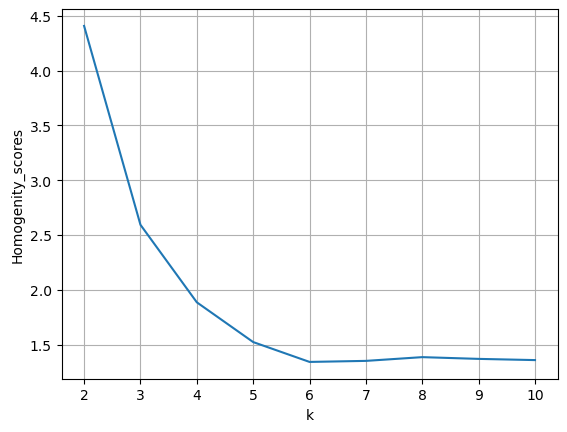

In [55]:
max_k = 10
homogenity_scores = []
for k in range(2, max_k + 1):
    kmeans_model = KMeans(n_clusters=k, n_init=10)
    y_pred_kmeans = kmeans_model.fit_predict(data_vector)
    homogenity_scores.append(1 / metrics.homogeneity_score(y_data, y_pred_kmeans))

plt.figure(figsize=(8, 4))
plt.plot(range(2, max_k + 1), homogenity_scores)
plt.xlabel('k')
plt.ylabel('Homogenity_scores')
plt.grid()

Based on the plot obtained from the elbow method, we have determined that the optimal value for `k` is $6$.

In [27]:
N_CLUSTERS = 6

kmeans = KMeans(n_clusters=N_CLUSTERS, n_init=20)

y_pred_kmeans = kmeans.fit_predict(data_vector)

### <a id='toc5_2_'></a>DBSCAN [](#toc0_)
Clustering based on density (local density criterion), such as density-connected points.

Each cluster has a considerable higher density of points than outside of the cluster.

#### <a id='toc5_2_1_'></a>Advantages [](#toc0_)
* Can discover arbitrarily shaped clusters.
* Find cluster completely surrounded by different clusters.
* Robust towards outlier detection (noise).


#### <a id='toc5_2_2_'></a>Disadvantages [](#toc0_)
* Sensitive to clustering parameters `minPoints` and `eps`. Choosing a meaningful ``eps` value can be difficult if the data isn't well understood.
* Fails to identify cluster if density varies and if the dataset is too sparse.

#### <a id='toc5_2_3_'></a>Find Optimal `EPS` [](#toc0_)

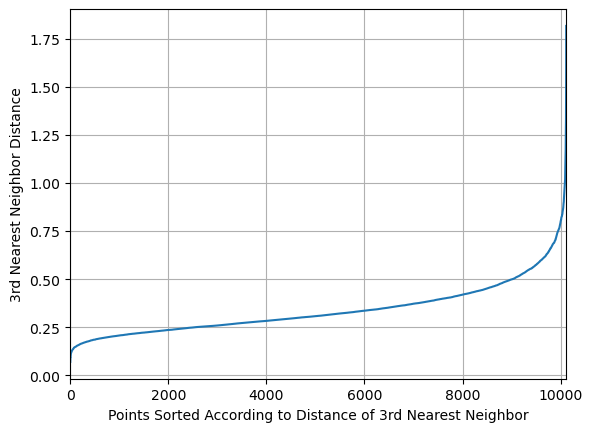

In [161]:
MIN_SAMPLES = 3

k = MIN_SAMPLES
kth_nearest_distance = []
for vector in data_vector:
    distances = [np.linalg.norm(vector - neighbor) for neighbor in data_vector]
    kth_nearest_distance.append(sorted(distances)[k - 1])

def plot_knn_distance(kth_nearest_distance, EPS=None):
    plt.plot(sorted(kth_nearest_distance))
    if EPS != None:
        plt.plot(EPS * np.ones(len(data_vector)), '--')
    plt.xlabel(f'Points Sorted According to Distance of {k}rd Nearest Neighbor')
    plt.ylabel(f'{k}rd Nearest Neighbor Distance')
    plt.xlim((0,len(kth_nearest_distance)))
    plt.grid()

plot_knn_distance(kth_nearest_distance)

Based on the plot obtained, we have determined that the optimal value for `eps` is $0.375$.

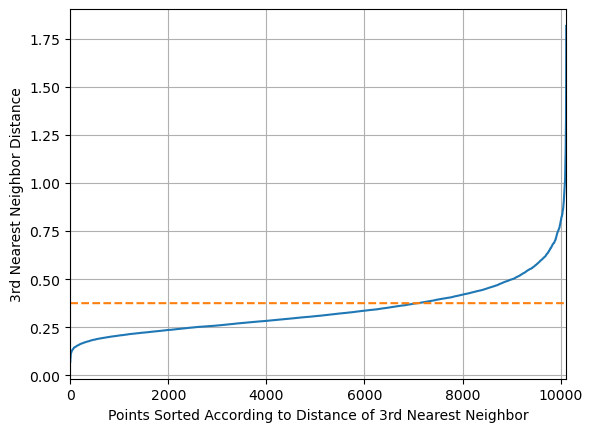

In [166]:
EPS = 0.375

plot_knn_distance(kth_nearest_distance, EPS=EPS)

In [162]:
dbscan = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES)

y_pred_dbscan = dbscan.fit_predict(data_vector)

## <a id='toc6_'></a>PCA [](#toc0_)

Obviously we cannot visualize more than 3 dimensions  all at once. However we can pick two or three factor but if we do it this way then we lose some possibly valuable information.
PCA is all about taking all factor, combining them in a smart way and producing new factor that are not correlated with each other and ranked from most important to least important.
These new factor are called principal components.

To peak the first component, pca asks the following question:

How can we arrange all points on a line in a way that preserves as much information as possible.

$$
max \sum_{i}  (x_{i}^{T} u)^2   \qquad \text{(info preserved)}
$$
By solving these optimaization equation we get the following results:

$$
Cu = \lambda u \\
C = \frac{1}{n} \sum_{i} x_{i}x_{i}^{T} \quad \text{(cov matrix)}
$$

More generally the directions picked by PCA are exactly the eigenvectors of covariance matrix.
Eigenvalue, however, shows how much information does this component has.







In [42]:
def plt_clusters(feature_vector, labels, title):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(feature_vector)
    plt.figure(figsize=(10, 6))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(title)
    plt.show()

### <a id='toc6_1_'></a>KMeans [](#toc0_)

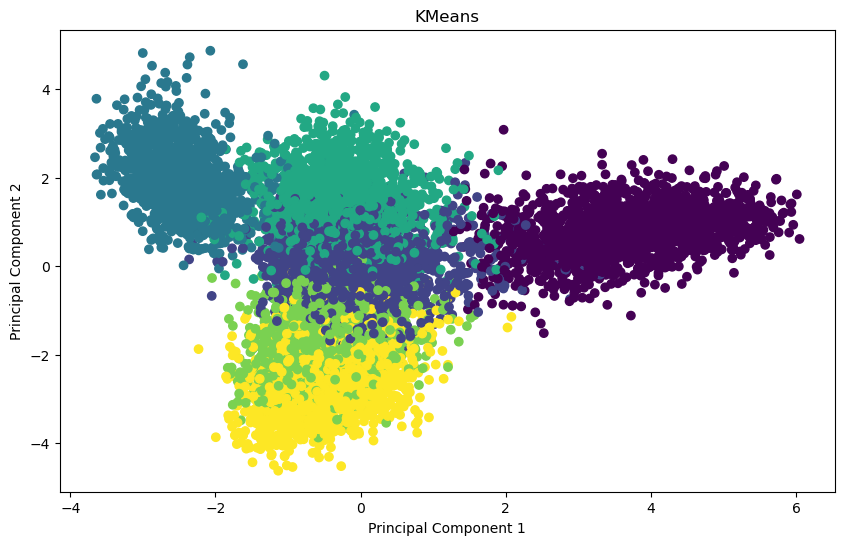

In [30]:
plt_clusters(data_vector, y_pred_kmeans, 'KMeans')

### <a id='toc6_2_'></a>DBSCAN [](#toc0_)

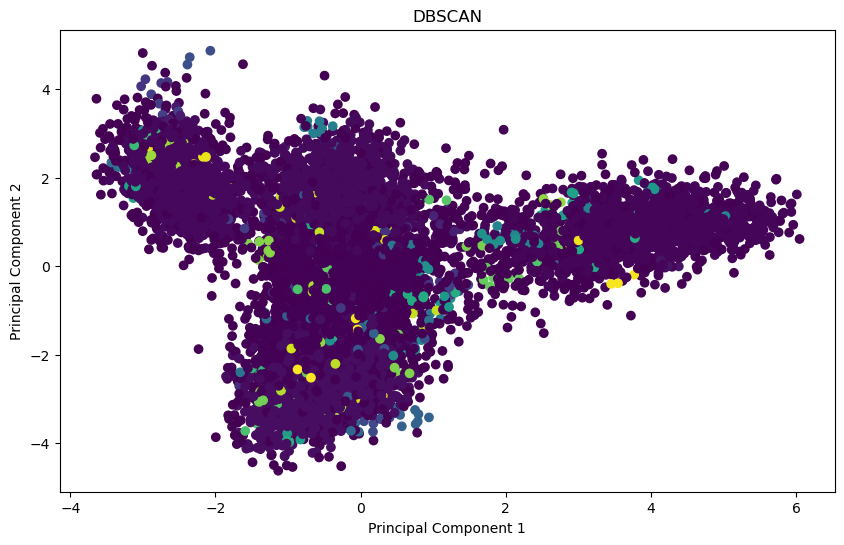

In [47]:
plt_clusters(data_vector, y_pred_dbscan, 'DBSCAN')

## <a id='toc7_'></a>Evaluation [](#toc0_)

### <a id='toc7_1_'></a>Homogeneity Score [](#toc0_)
This score is useful to check whether the clustering algorithm meets an important requirement: a cluster should contain only samples belonging tp a single class. It's defined as:
$$
h = 1 - \frac{H(Y_{true}| Y_{pred}) }{H(Y_{true})}
$$
where $H$ is entropy.
It's bounded between $0$ and $1$, with low values indicating a low homogeneity. In fact, when the knowledge of $Y_{pred}$ reduces the uncertainty of $Y_{true}$, $H(Y_{true}|Y_{pred})$ become smaller and viceversa. 

### <a id='toc7_2_'></a>Silhouette Score [](#toc0_)
The silhouette score is a numerical value between $-1$ and $1$ that indicates how well a data point belongs to its cluster and how seprated it is from other clusters. A high silhouette score means that the data point is close to the average distance of its cluster and far from the nearest neighboring cluster, implying a good clustering. A low silhouette score means that the data points is far from the average distance of its cluster and close to another cluster, implying a poor clustering. A silhoutte score of 0 means that the data point is on the border of two clusters indicating an ambiguous clustering.

To calculating the silhouette score for data point, you need to compute two values: a and b. a is the average distance of data point to all other data points in the same cluster. b is the minimum avverage distance of the data point to all other data points in any other cluster. The silhoutte score for the data point is the n given by formula:
$$
s = \frac{(b - a)}{max(a, b)}
$$
The higher the average silhouette score, the better the clustering algorithm.

In [53]:
kmeans_homogeneity = metrics.homogeneity_score(y_data, y_pred_kmeans)
kmeans_silhouette = metrics.silhouette_score(data_vector, y_pred_kmeans)
dbscan_homogeneity = metrics.homogeneity_score(y_data, y_pred_dbscan)
dbscan_silhouette = metrics.silhouette_score(data_vector, y_pred_dbscan)

print('Cluster Evaluation for KMeans:')
print(f'\u25CF Homogeneity: {kmeans_homogeneity:.2f}')
print(f'\u25CF Silhouette:  {kmeans_silhouette:.2f}\n')

print('Cluster Evaluation for DBSCAN:')
print(f'\u25CF Homogeneity: {dbscan_homogeneity:.2f}')
print(f'\u25CF Silhouette:  {dbscan_silhouette:.2f}')

Cluster Evaluation for KMeans:
● Homogeneity: 0.87
● Silhouette:  0.51

Cluster Evaluation for DBSCAN:
● Homogeneity: 0.67
● Silhouette:  -0.46


### <a id='toc7_3_'></a>Results [](#toc0_)
Here, we aimed to cluster the data in order to align with the existing clusters from before, as opposed to solely creating the best possible clusters from the available data. This point is crucial because the silhouette score, which is typically used to evaluate clustering performance, is low for both algorithms. This score is more suited for evaluating the latter type of clustering mentioned.

Now, when it comes to the homogeneity score, we can compare the two algorithms. KMeans performs reasonably well, with a score of around 87%. However, DBSCAN performs very poorly, as you can see in PCA plot. Why is that? The initial solution that comes to mind is to experiment with different hyperparameters, but I have already tried numerous combinations. I believe the issue lies in the way DBSCAN operates, as it assumes the same density for all clusters. However, in our specific example, the clusters do not exhibit the same density. 

**NOTE**: Adjusting the hyperparameters can yield a higher silhouette score, and I have explored such possibilities. Nevertheless, our objective here is not solely focused on maximizing the silhouette score. 

## <a id='toc8_'></a>Further Improvements and Recommendations [](#toc0_)
To improve the clustering results, we can explore the following topics:

* Change the distance function and feature weighting.

* Normalize the density of different clusters.

* Find a better way to convert text to vectors.

<a name='7'></a>
## <a id='toc9_'></a>Refrences [](#toc0_)
* [Word2Vec Tutorial - The Skip-Gram Model](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)
* [A gentle introduction to Doc2Vec](https://medium.com/wisio/a-gentle-introduction-to-doc2vec-db3e8c0cce5e#:~:text=Using%20gensim%20doc2vec%20is%20very,to%20document%20will%20be%20predicted.)
* [Explanation of Principal Component Analysis (PCA)](https://builtin.com/data-science/step-step-explanation-principal-component-analysis)
* [Homogeneity score](https://www.oreilly.com/library/view/mastering-machine-learning/9781788621113/2830f738-c6a5-460a-b518-23ecd3745c2d.xhtml)
* [How can you calculate the silhouette score for a clustering algorithm?](https://www.linkedin.com/advice/0/how-can-you-calculate-silhouette-score-clustering-algorithm-w9bcc#:~:text=The%20idea%20is%20to%20calculate, )
